
📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 10.9 seconds
⚠️  10.9s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical quotes: 7,105
   Non-conver

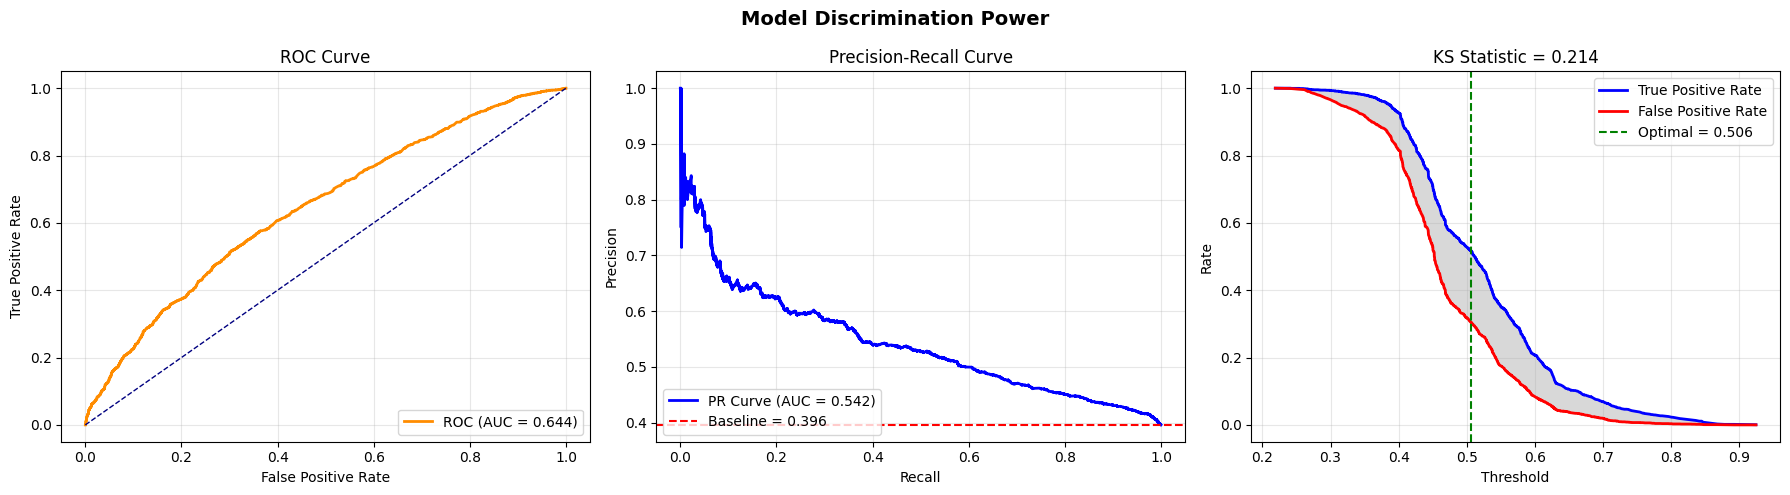

• ROC-AUC: 0.6445
• PR-AUC: 0.5416
• KS Statistic: 0.214 (WEAK discrimination)
• Optimal Threshold: 0.506

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.695
Decile 10 mean prob: 0.332


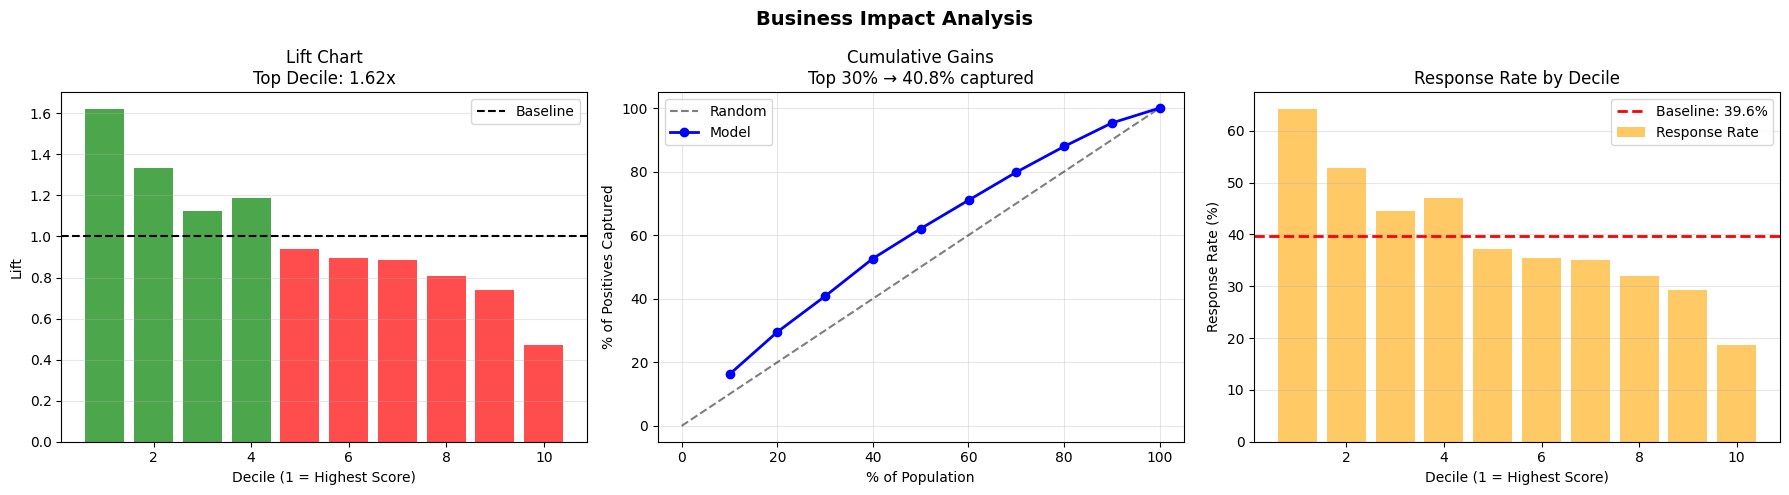

• Top Decile Lift: 0.47x
• Top 30% captures: 40.8% of positives
• Baseline response rate: 39.6%
• Top decile response: 64.2%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


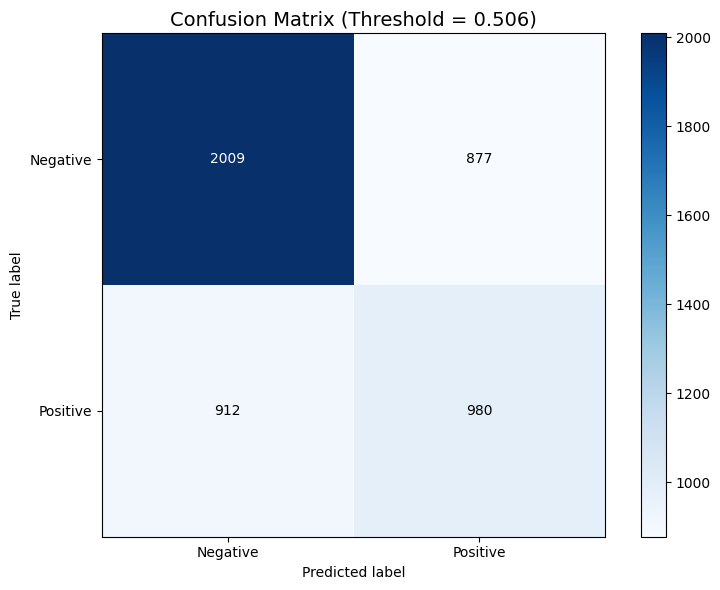

At threshold 0.506:
• Accuracy: 0.626
• Precision: 0.528
• Recall: 0.518
• F1-Score: 0.523
• True Positives: 980
• False Positives: 877
• True Negatives: 2009
• False Negatives: 912

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.214 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.47x better than random
   Coverage: Top 30% → 40.8% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6445 (Excellent if >0.8)
   PR-AUC: 0.5416 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.506
   Precision at threshold: 0.528
   Recall at threshold: 0.518

🧪 TEST 2: SEQUENCE FEATURES (Advanced)
✓ Model saved: sequence_prediction_model.pkl
✓ AUC: 0.659
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


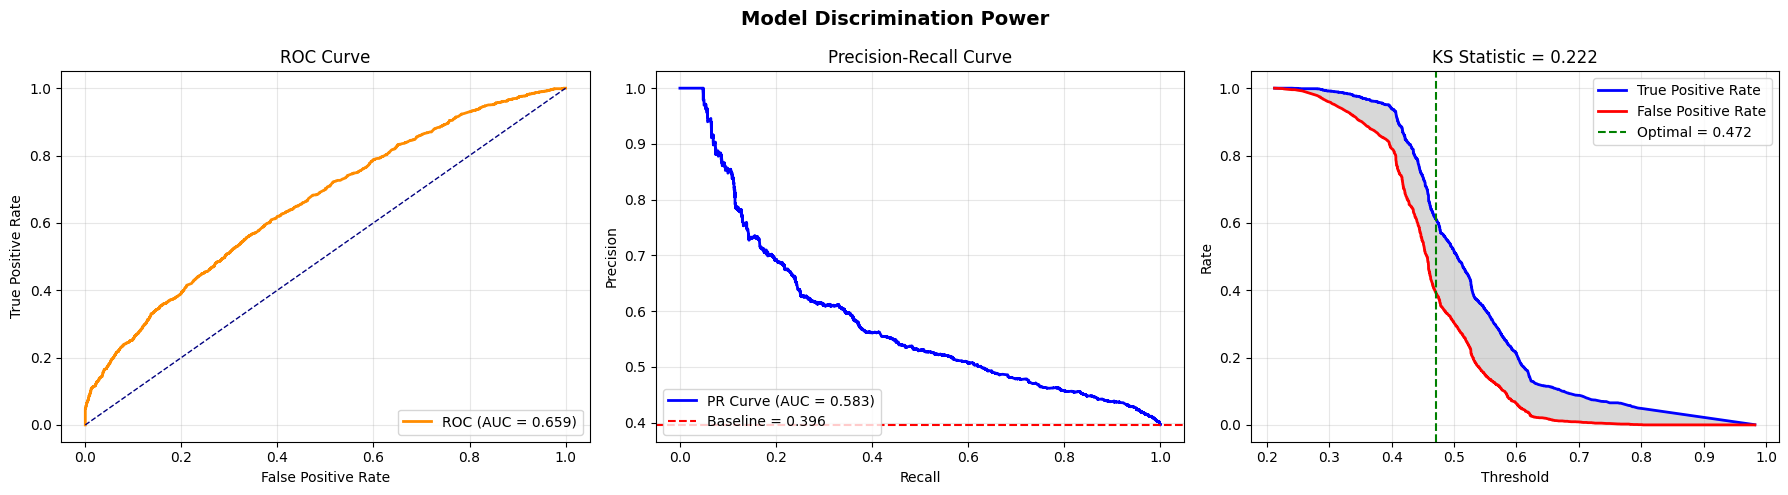

• ROC-AUC: 0.6592
• PR-AUC: 0.5834
• KS Statistic: 0.222 (WEAK discrimination)
• Optimal Threshold: 0.472

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.711
Decile 10 mean prob: 0.324


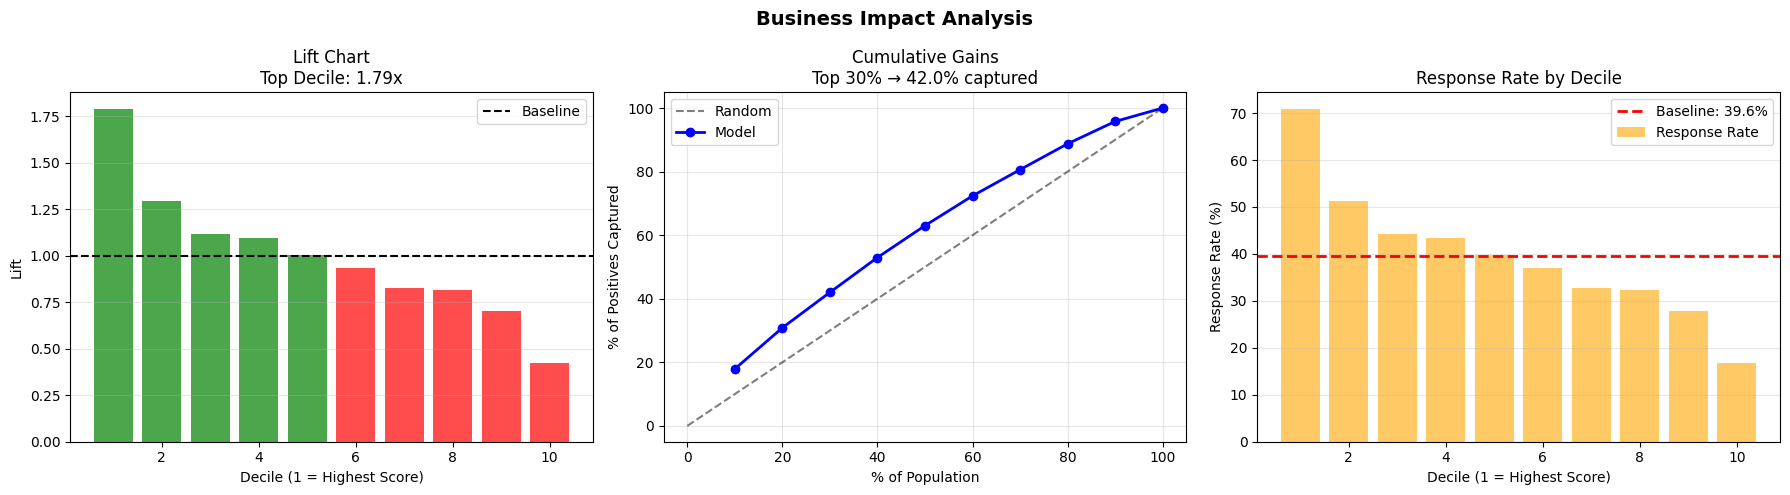

• Top Decile Lift: 0.42x
• Top 30% captures: 42.0% of positives
• Baseline response rate: 39.6%
• Top decile response: 70.9%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


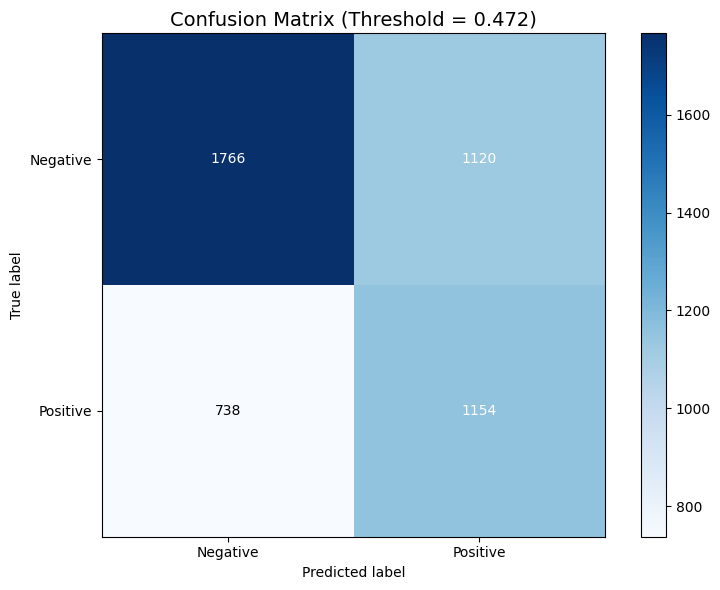

At threshold 0.472:
• Accuracy: 0.611
• Precision: 0.507
• Recall: 0.610
• F1-Score: 0.554
• True Positives: 1154
• False Positives: 1120
• True Negatives: 1766
• False Negatives: 738

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.222 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.42x better than random
   Coverage: Top 30% → 42.0% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.6592 (Excellent if >0.8)
   PR-AUC: 0.5834 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.472
   Precision at threshold: 0.507
   Recall at threshold: 0.610

🧪 TEST 3: NEW FEATURES (Advanced)
✓ Model saved: new_prediction_model.pkl
✓ AUC: 0.704
COMPLETE MODEL VALIDATION PACKAGE

📊 STEP 1: DISCRIMINATION POWER
----------------------------------------


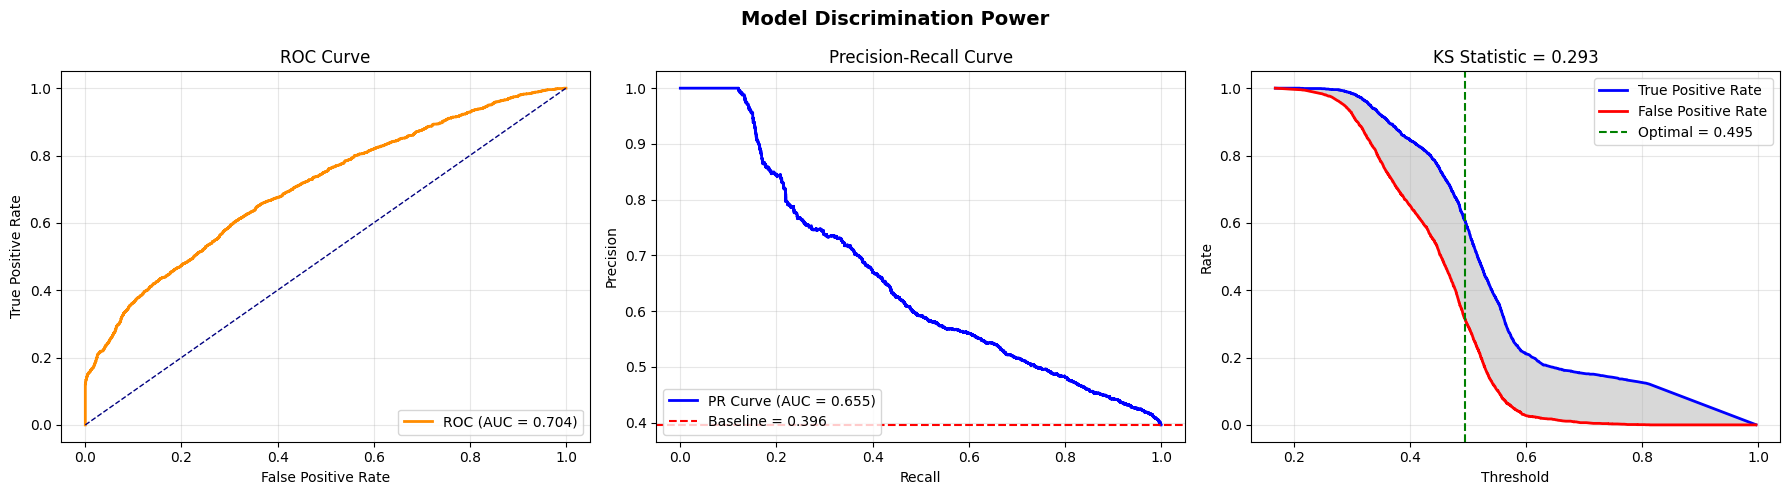

• ROC-AUC: 0.7040
• PR-AUC: 0.6545
• KS Statistic: 0.293 (WEAK discrimination)
• Optimal Threshold: 0.495

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.797
Decile 10 mean prob: 0.290


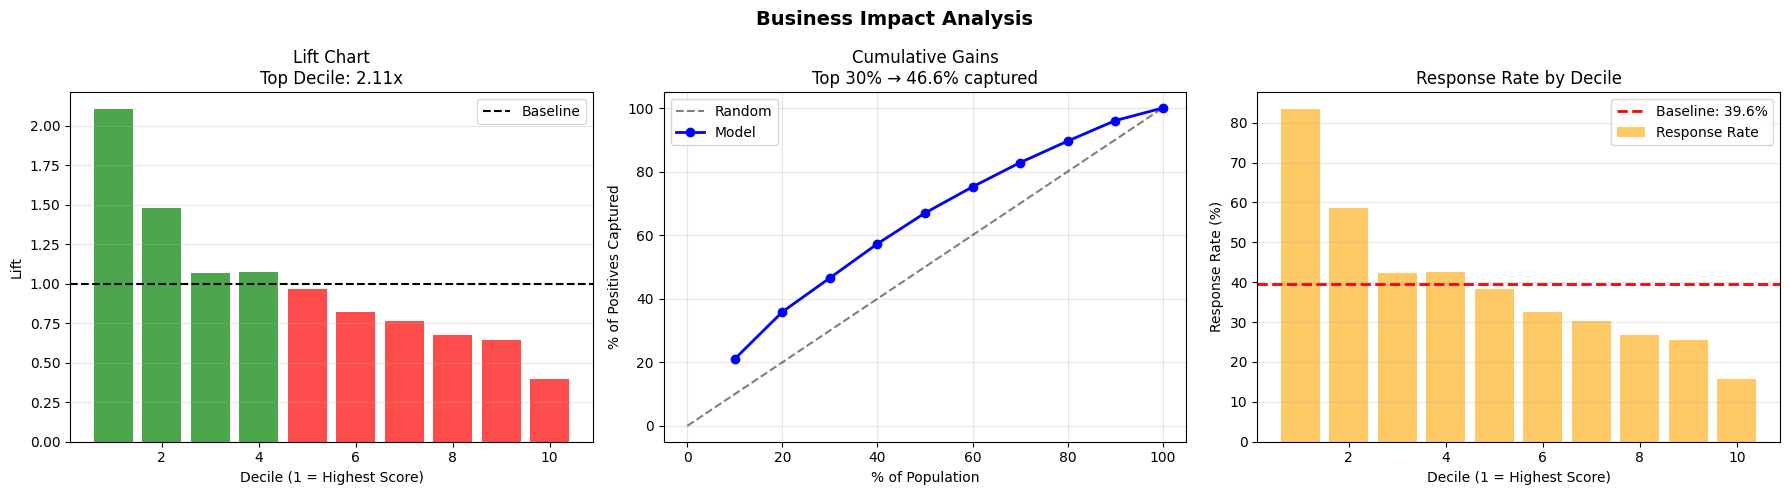

• Top Decile Lift: 0.40x
• Top 30% captures: 46.6% of positives
• Baseline response rate: 39.6%
• Top decile response: 83.5%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


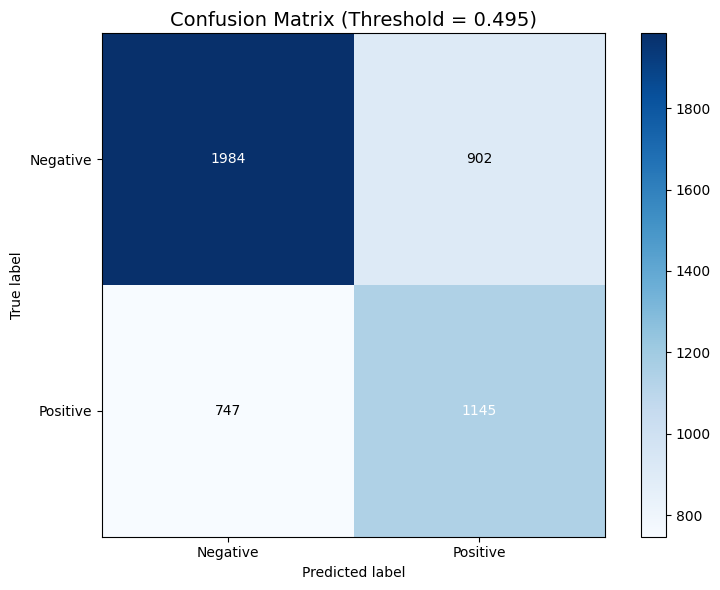

At threshold 0.495:
• Accuracy: 0.655
• Precision: 0.559
• Recall: 0.605
• F1-Score: 0.581
• True Positives: 1145
• False Positives: 902
• True Negatives: 1984
• False Negatives: 747

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.293 (WEAK discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.40x better than random
   Coverage: Top 30% → 46.6% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7040 (Excellent if >0.8)
   PR-AUC: 0.6545 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.495
   Precision at threshold: 0.559
   Recall at threshold: 0.605


{'y_true': array([0., 0., 0., ..., 1., 0., 1.], shape=(4778,)),
 'y_pred_proba': array([0.29294289, 0.31888378, 0.6541965 , ..., 0.53107233, 0.41106158,
        0.51682989], shape=(4778,)),
 'y_pred': array([0, 0, 1, ..., 1, 0, 1], shape=(4778,)),
 'roc_auc': 0.7039801938057753,
 'pr_auc': 0.6545360252813381,
 'ks_statistic': np.float64(0.2926363914736008),
 'optimal_threshold': np.float64(0.4953022243495898),
 'top_decile_lift': np.float64(0.3962400594443019),
 'decile_stats':    decile  count  positives  mean_prob  response_rate      lift  \
 0       1    478      399.0   0.796989       0.834728  2.107997   
 1       2    478      280.0   0.571092       0.585774  1.479296   
 2       3    478      202.0   0.537278       0.422594  1.067207   
 3       4    477      203.0   0.513047       0.425577  1.074738   
 4       5    478      183.0   0.490595       0.382845  0.966826   
 5       6    478      156.0   0.467397       0.326360  0.824179   
 6       7    477      144.0   0.436910   

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_features.correction_features import create_correction_features
from ml_features.catboost_interaction_features import create_catboost_interaction_features
from ml_features.efficiency_interation_features import create_efficiency_interaction_features
from ml_features.engagement_interation_features import create_engagement_interaction_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report
from ml_evaluation.error_analysis import comprehensive_error_analysis, analyze_feature_contribution_to_errors, create_error_visualization


import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")


print("\n" + "="*80)
print("STRATEGY: CREATE FEATURES")
print("="*80)


# Create feature list
feature_funcs = [create_customer_features, create_sequence_features, create_brand_features, 
                 create_model_features, create_market_features,
                 create_equipment_features, create_solution_complexity_features,
                 create_timeline_features, create_advanced_timeline_features,
                 create_commercial_role_features, create_process_features
                 , create_correction_features
                ]


new_df = feature_funcs[0](df_quotes)
customer_df = new_df
for func in feature_funcs[1:]:
    new_df_ = func(df_quotes)

    new_df = pd.merge(new_df, new_df_, on='numero_compte', how='left', suffixes=('_dup', ''))
    new_df = new_df.drop(columns=[x for x in new_df.columns if '_dup' in x], errors='ignore')
    print(len(new_df))
    if func == create_sequence_features: sequence_df = new_df


# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

X_sequence = sequence_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")

new_df = create_timeline_interaction_features(new_df)
new_df, _ = create_catboost_interaction_features(new_df)
new_df, _ = create_efficiency_interaction_features(new_df)
new_df, _ = create_engagement_interaction_features(new_df)

X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")


print("\n" + "="*80)
print("TESTING FEATURE IMPROVEMENT")
print("="*80)

# Test 1: Customer features only (baseline)
print("\n🧪 TEST 1: ENHANCED CUSTOMER FEATURES (Baseline)")
result = train_rf(X_customer_clean, y_customer_clean, 'improved_customer_model')
df = result['X_test']
df['converted'] = result['y_test']
model_evaluation_report(df, result['model'], result['features'], 'converted')

# Test 2: Sequence features (if available)
print("\n🧪 TEST 2: SEQUENCE FEATURES (Advanced)")
result = train_rf(X_sequence_clean, y_sequence_clean, 'sequence_prediction_model')
df = result['X_test']
df['converted'] = result['y_test']
model_evaluation_report(df, result['model'], result['features'], 'converted')


# Test 3: New features 
print("\n🧪 TEST 3: NEW FEATURES (Advanced)")
result = train_rf(X_new_clean, y_new_clean, 'new_prediction_model')
df = result['X_test']
df['converted'] = result['y_test']
model_evaluation_report(df, result['model'], result['features'], 'converted')

COMPREHENSIVE ERROR ANALYSIS

📊 1. BASIC ERROR METRICS
------------------------------------------------------------
Confusion Matrix:
  True Negatives:    2038 (Correctly rejected)
  False Positives:    848 (Predicted YES, actual NO) ← WASTED EFFORT
  False Negatives:    792 (Predicted NO, actual YES) ← MISSED OPPORTUNITIES
  True Positives:    1100 (Correctly predicted)

Error Analysis:
  • Total errors: 1,640 (34.3% of predictions)
  • False Positive rate: 17.7% (wasted sales effort)
  • False Negative rate: 16.6% (missed conversions)

📈 2. PREDICTION CONFIDENCE ANALYSIS
------------------------------------------------------------
Accuracy by Confidence Level:
  • Very Low   confidence: 87.6% accurate (250 predictions)
  • Low        confidence: 75.1% accurate (1,049 predictions)
  • Medium     confidence: 57.7% accurate (3,001 predictions)
  • High       confidence: 64.9% accurate (171 predictions)
  • Very High  confidence: 93.8% accurate (307 predictions)

⚠️  Low Confidence Predi

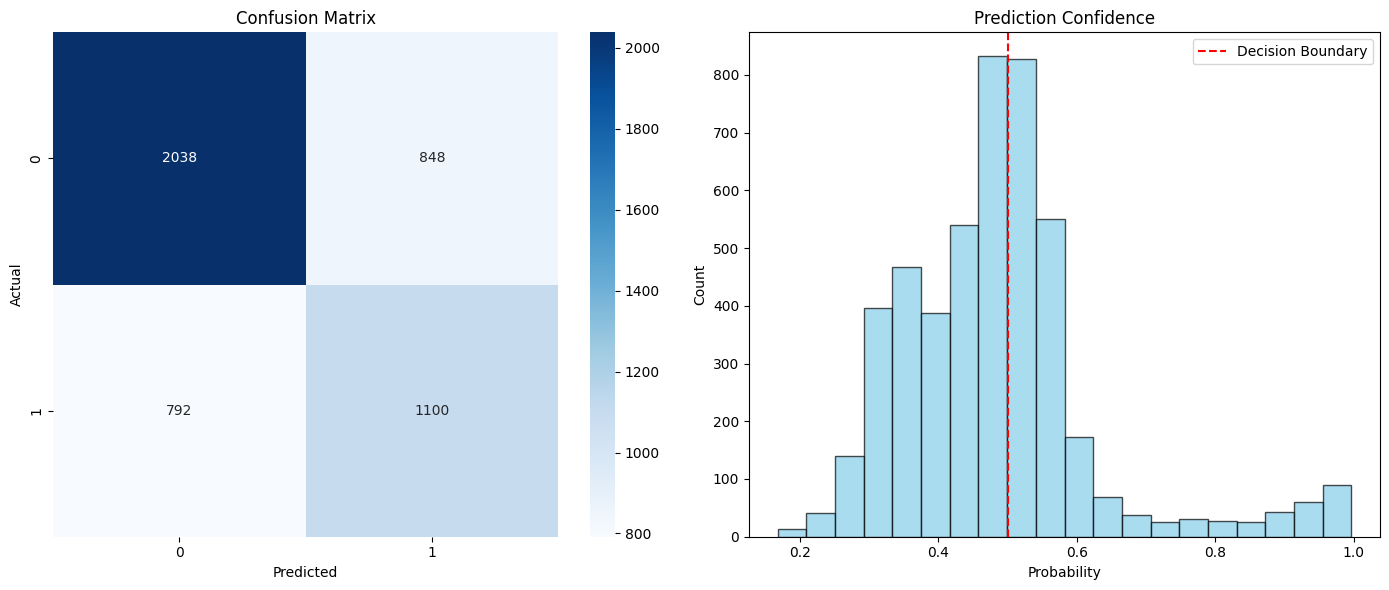

In [2]:
X_test = result['X_test'].copy()  # Make a copy to avoid modifying the original
y_test = result['y_test']
model = result['model']

# Ensure X_test doesn't have the target column
if 'converted' in X_test.columns:
    X_test = X_test.drop(columns=['converted'])

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

# Create a dataframe for error analysis that includes the predictions
error_df = X_test.copy()
error_df['converted'] = y_test
error_df['predicted'] = y_pred
if y_pred_proba is not None:
    error_df['prediction_probability'] = y_pred_proba

error_results = comprehensive_error_analysis(
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    original_df=error_df,  # Use the properly prepared dataframe
    customer_id_col='numero_compte'
)

analyze_feature_contribution_to_errors(model, X_test, y_test, y_pred)
create_error_visualization(error_results, y_test, y_pred, y_pred_proba)